<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/WS2_Students__manorz_dec12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>236606 - Machine Learning and Human Behavior</h1>
<h2>Workshop #2 - Discrete Choice ✨</h2>
</center>

## Preliminaries
Run these cells to load into memory objects and functions that will be used throughtout today's workshop.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import abc
import string
import statsmodels.api as sm
import itertools
from sklearn import svm, linear_model
import pandas as pd
import sys

from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Context UserModels**

In [3]:
# Generate Choice 

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    raise NotImplementedError()


In [26]:
# user model types - paste your user model here!

class RationalUserModel(UserModel):

  def __init__(self, num_features, beta_h):
    self.num_features = num_features
    self.beta_h = beta_h

  def __call__(self, X):
    return X@self.beta_h
  
  def choice(self, X):
    return np.argmax(self(X), axis=0)

class AttractionUserModel(UserModel):

  def __init__(self, beta_h, alpha_attr):
    self.beta_h = beta_h
    self.beta_attr = alpha_attr

  def find_dominent(self,X):

    """ for each item:
     find a dominating item /
    declare as a dominating item/
    neither"""
    self.dominent = np.ones(X.shape[0]) * -1
    self.dominent_over = {i:[] for i in range(X.shape[0])}

    max_a = np.argmax(X, axis=0)

    if np.all(max_a == max_a[0]):
        self.dominent = np.ones(X.shape[0]) * max_a[0]
        self.dominent_over[max_a[0]] = [i for i in range(X.shape[0])]
        self.dominent_over[max_a[0]].pop(max_a[0])

    else:
      for i in range(X.shape[0]):
            for j in range(X.shape[0]):

              if (self.dominent[i] == -1):
                if np.all(X[i] < X[j]):
                  self.dominent[i] = j
                  self.dominent_over[j].append(int(i))

              elif np.all(X[j,:] >= X[int(self.dominent[i]),:]):
                  self.dominent[i] = j
                  self.dominent_over[j].append(int(i))


  def __call__(self, X):

    # calculate actual value
    v_ih = X@self.beta_h

    # calculate perference vector
    pref_vec = X.max(axis=0) - X.min(axis=0)

    # project matrix on vector
    X_projected = np.zeros(X.shape)
    projection_size = np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        X_projected[i, :] = (X[i,:].dot(pref_vec) / np.linalg.norm(pref_vec)) * pref_vec
        projection_size[i] = np.linalg.norm( X_projected[i, :])
    # calculate utility based on dominant
    utility = np.zeros(X.shape[0])
    self.find_dominent(X)
    
    for i in range(X.shape[0]):
      if self.dominent[i] != -1:
        utility[i] = projection_size[int(self.dominent[i])] - projection_size[i]
      if utility[i] == 0: # then i is either dominant or neither
        if len(self.dominent_over[i]) > 0:
          utility[i] = np.max([projection_size[int(self.dominent[int(x)])] - projection_size[ int(x)] for x in self.dominent_over[i]])
    # print(f'rational value: {X@self.beta_h}')
    # print(f'attraction value: {self.beta_attr * utility}')
    return X@self.beta_h + self.beta_attr * utility
  
  def choice(self, X):
    return np.argmax(self(X), axis=0)



class SimilarityUserModel(UserModel):

  def __init__(self, beta_h, beta_sim):
    self.beta_h = beta_h
    self.beta_sim = beta_sim

  def __call__(self, X):

    # calculate actual value
    v_ih = X@self.beta_h

    # calculate perference vector
    pref_vec = X.max(axis=0) - X.min(axis=0)


    # project on the ortogonal hyperplane
    X_projected = np.zeros(X.shape)
    projection_size = np.zeros(X.shape[0])

    for i in range(X.shape[0]):
        X_projected[i, :] = X[i,:] -  (X[i,:].dot(pref_vec) / np.linalg.norm(pref_vec)) * pref_vec

    # find min distance on projected

    distances = np.zeros((X_projected.shape[0], X_projected.shape[0]))

    for i in range(X_projected.shape[0]): # could be optimized (cal half mat etc..)
      for j in range(X_projected.shape[0]):
        distances[i,j] = np.linalg.norm(X_projected[i,:] - X_projected[j,:])
    
    # avoide i == j
    distances = distances + np.eye(distances.shape[0])*distances.max()

    min_distances = distances.min(axis=1) # go over columns

    return v_ih + self.beta_sim*-min_distances
  
  def choice(self, X):
    return np.argmax(self(X))

class CompromiseUserModel(UserModel):
  
  def __init__(self, beta: np.ndarray, alpha: float):
    self.beta = beta
    self.alpha = alpha

  def _com(self, X: np.ndarray) -> np.ndarray:
    N, Q = X.shape  # (#items, #features)
    r = (np.min(X, axis=0, keepdims=True) + np.max(X, axis=0, keepdims=True)) / 2
    # r = np.expand_dims(r, 0)
    # r = np.repeat(r, N, axis=0)
    com = -np.linalg.norm(X - r, ord=2, axis=1)
    return com

  def __call__(self, X, *args) -> np.ndarray:
    M, N, Q = X.shape  # (#sets, #items, #features)
    v = np.zeros((M, N))
    for m in range(M):
      v[m, :] = X[m] @ self.beta + self.alpha * self._com(X[m])
    return v
  
  def choice(self, X: np.ndarray, *args) -> np.ndarray:
    M, N, Q = X.shape  # (#sets, #items, #features)
    choice = np.argmax(self(X, *args), axis=1)
    return choice

**Synthetic Data Generation**

In [34]:
np.random.seed(42)

# just data
def generate_synth_data(num_examples, num_features, num_items):
  items = np.random.uniform(low=0.0, high=10.0, size=(num_examples, num_items, num_features))
  return items

beta_com = 100
beta_atter = 100
beta_sim = 100

# data and user behavior
def generate_data_and_user_selections(num_examples=100, num_items=5, num_features=3):
  """ returns data and dictionary with user predictions for each user model """
  beta_h = np.arange(num_features) * 1

  X = generate_synth_data(num_examples, num_features, num_items)
  args = {"beta_h":beta_h, "beta_com":beta_com} 

  a_user = AttractionUserModel(beta_h, beta_atter)
  c_user = CompromiseUserModel(beta_h, beta_com)
  s_user = SimilarityUserModel(beta_h, beta_sim)
  r_user = RationalUserModel(num_features, beta_h)

  y_r = np.zeros((num_examples, num_items))
  y_c = np.zeros((num_examples, num_items))
  y_s = np.zeros((num_examples, num_items))
  y_a = np.zeros((num_examples, num_items))

  for i in range(num_examples):
    selection = a_user.choice(X[i])
    y_a[i, selection] = 1
    selection = r_user.choice(X[i])
    y_r[i, selection] = 1
    # selection = c_user.choice(X[i])
    selection = c_user.choice(X[i].reshape((1, num_items, num_features))).squeeze()
    y_c[i, selection] = 1
    selection = s_user.choice(X[i])
    y_s[i, selection] = 1
  
  # return X, {'Rational':y_r, 'Compromise':y_c, 'Similarity':y_s, 'Attraction':y_a}
  return X, {'Rational':y_r, 'Compromise':y_c, 'Similarity':y_s, 'Attraction':y_a}, {'Rational':r_user, 'Compromise':c_user, 'Similarity':s_user, 'Attraction':a_user}




-----------------
-----------------

## Task 1: engineering choice sets

In this task, you will play "evil designer" and construct sets of available items that cause (non-rational) users to choose items that are bad for them (i.e., have suboptimal value), but good for the system. In particular, users in this task will be susceptible to the *Attracttion* context effect, and the way you construct the set of items should make use of this knowledge.

----------------------------------------

**Recommendation procedure:**
1. The collection of available items is the *ground set* $\Omega=\{x_1,...,x_n\}$ ($n$ may be different in different parts of this task). Each item $x \in s$ is described by two features, $x=(x_1, x_2)$.
2. There is a single user whose (true) value function is $v(x)=\alpha^\top x$. I.e., if the user chooses item $x_i$, then she receives $\alpha_1\cdot x_{i1} + \alpha_2\cdot x_{i2}$ utility from this choice. **The value vector $\alpha$ is known to the system**.
3. System also benefits from user choices. If the user chooses item $x_i$, then the system receives $e_i$ utility. The values $e_i$ are predetermined, known to the system, and do not depend on features.
4. The system recommends to the user the top-5 items $x\in \Omega$ having highest value. We will call this the *choice set*, denoted $s \in \Omega$.
5. The user chooses exactly one item $x \in s$. This is the item with highest *perceived value*, as determined by the attraction effect:
$$
  \tilde{v}(x|s) = \alpha^\top x + \mathtt{att}(x|s)
$$
where $\mathtt{att}$ is as was defined in class. We will denote the chosen item by $y = \mathtt{argmax}_{x \in s} \tilde{v}(x|s)$.
6. User receives utility $v(y)$, and system receives utility $e_y$.

----------------------------------------

In the above description, the system recommends in a way that is optimal to users. In this task, *you are an agent of the system*, and your goal is to maximize the system's utility.

Of course, you cannot simply force the user to choose a certain item, nor can you change the recommendation procedure. The only thing you are allowed to do is to modify $\Omega$ by adding one additional item from a different set of items, $\Omega'$. Once $\Omega$ is modified (i.e., includes one additional item), the recommendation procedure and user choice behavior is as described above.
Hence, your goal is to (manually) choose $x \in \Omega$ such that the choice $y$ derived from a top-5 recommended set $s$ based on the collection of items $\Omega \cup \{x\}$ will results in high system utility $e_y$ (and possibly with lower utility $v(y)$ to the user).

As you will see, items in  $\Omega'$ actually have lower system values $e_i$ than items in $\Omega$ ($\forall e \in E_S, e' \in E_S':  e > e'$). Therefore, the item you add will serve as a *decoy*: these serve to modify the preceived values of items in $s$, in a way that utilizes the attraction effect to affect choice behavior. 

### 1.1 Guided example - a gentle start:

Set $\Omega$ consists of 7 items:

\begin{align}
{A:(1,1), B:(3,7.5), C:(3,5), D:(4,4), E:(10,5), F:(4,6), G:(2,1)}
\end{align}

with the following system utility values $e_s=\{e_1,\dots,e_n\}$:
\begin{align}
\{10, 20, 30, 40, 30, 80, 100\}
\end{align}

Additionally, we have set $\Omega'$:
\begin{align}
{I:(4,4.5), J:(2.5,6), K:(4.5,5)}
\end{align}
with the following values $e_{s'}$:
\begin{align}
\{5, 8, 3\}
\end{align}

The parameter $\alpha$ of the user value function is: 
\begin{align}
\alpha_1 = 2, \alpha_2 = 3
\end{align}

------------

1.1.1 First, let's see what happens before you intervene. Run the code below to see what 5 items are recommended by the system when $\Omega$ is the ground set,
and what item the user chooses. Make sure you understand what the code does.

In [6]:
# Our data:
omega = np.array(
    [[1,  3,    3,  4,  10, 4,  2],
     [1,  7.5,  5,  4,  5,  6,  1]]
)  # Set of 7 items from omega: A..G

E_s = np.array(
    [10, 20, 30, 40, 30, 80,100]
)

omega_tag = np.array(
    [[4,    2.5,  4.5],
     [4.5,  6,    5]]
)

E_s_tag = np.array(
    [5, 8, 3]
)

alpha = [2, 3] # rational user attributes

alpha_attr = 3   # attraction coefficient

a_user = AttractionUserModel( beta_h=np.array(alpha), alpha_attr=alpha_attr)

In [7]:
def rec_and_choose(omega, alpha):
  # system computes user values
  rantional_user_val = omega[0,:]*alpha[0] + omega[1,:]*alpha[1]
  
  # system recommends top-5 items
  top_5 = rantional_user_val.argsort()[-5:][::-1]

  # user chooses item with highest perceived value
  chosen = top_5[a_user.choice(omega[:,top_5].T)]

  return top_5, chosen, rantional_user_val

top_5, chosen, rantional_user_val = rec_and_choose(omega, alpha)

1.1.2 Print a table showing for each item (rows) the true value and perceived value for the user (columns).

In [8]:
import pandas as pd

df = pd.DataFrame(columns=("true value", "perceived value"))
df["true value"] = rantional_user_val
df["perceived value"] = a_user(omega.T)
df

,true value,perceived value
0,5.0,185.75
1,28.5,209.25
2,21.0,67.50
3,20.0,201.50
4,35.0,216.50
5,26.0,72.50
6,7.0,160.75


1.1.3 The following code block plots all items in 2D space and highlights the top-5 items and the user's choice:

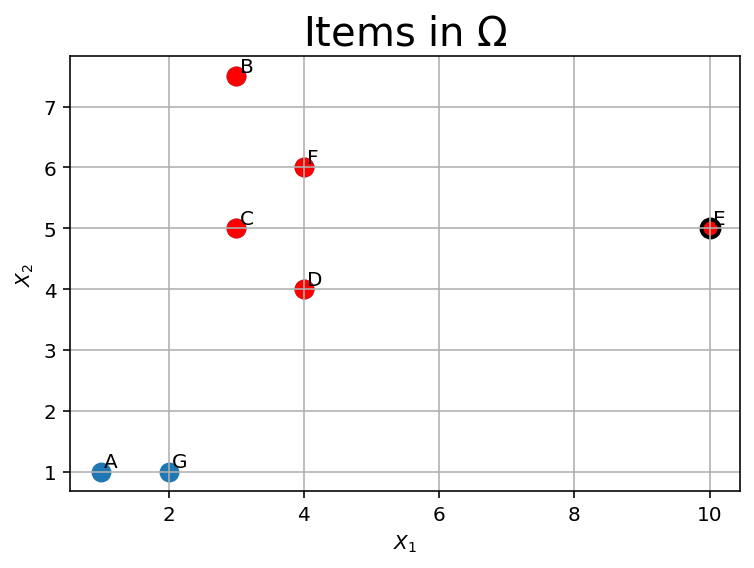

In [9]:
# plot over 

def plot_omega(omega, top_5, chosen):
  area = 20

  fig, ax = plt.subplots()
  ax.scatter(omega[0,:], omega[1,:], s=80,label="$\Omega$")
  plt.title('Items in $\Omega$', fontsize=20)
  plt.xlabel('$X_1$')
  plt.ylabel('$X_2$')
  plt.grid()
  # # color the top three items
  ax.scatter(omega[0,top_5], omega[1,top_5], s=80, color='red')
  # add annotations
  S_len = omega.shape[1]
  for i, txt in enumerate(string.ascii_uppercase[:S_len]):
      ax.annotate(txt, (omega[0,:][i]+0.05, omega[1,:][i]+0.07))
  ax.scatter(omega[0,chosen], omega[1,chosen], s=80, color='red',edgecolors='black',linewidths=2)

plot_omega(omega, top_5, chosen)

In the above plot, items in $\Omega$ are dots. Top-5 items that are currently selected from $\Omega$ are colored red, and all others are blue. The chosen item has a black border.

Some things to note:
* Items C and D are dominated by E and F (make sure you understand what this means, and why it holds).
* User chooses item E, meaning it has the highest perceived value. Here, item E also has the highest true value, and so the user is happy.
* The value to the system form the user choosing item E is $e_E=20$.

1.1.4 
What can you do to improve the system's utility?
The next block of code plots items in both $\Omega$ and $\Omega'$ in 2D space:

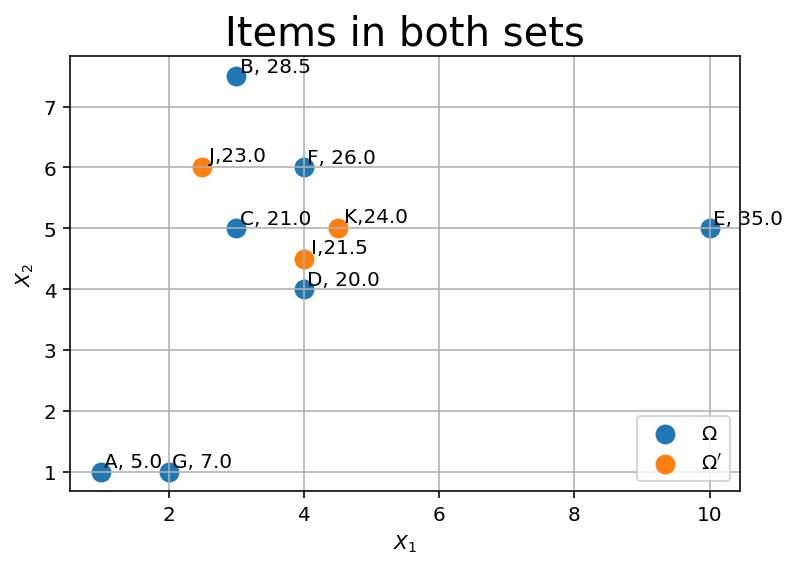

In [10]:
omega_tag_rational_user_val = omega_tag[0,:]*alpha[0] + omega_tag[1,:]*alpha[1]

def plot_two_sets(omega,omega_tag):
  area = 20

  fig, ax = plt.subplots()
  ax.scatter(omega[0,:], omega[1,:], s=80,label="$\Omega$")
  plt.title('Items in both sets', fontsize=20)
  plt.xlabel('$X_1$')
  plt.ylabel('$X_2$')
  plt.grid()
  # inspect set of decoyes 
  ax.scatter(omega_tag[0,:],omega_tag[1,:], s=80, label="$\Omega'$")
  plt.legend(loc='lower right')


  # add annotations and print user values
  S_len = omega.shape[1]
  Sw_s = S_len + 1
  Sw_len = Sw_s + omega_tag.shape[1]
  for i, txt in enumerate(string.ascii_uppercase[:S_len]):
      ax.annotate(f'{txt}, {rantional_user_val[i]}', (omega[0,:][i]+0.05, omega[1,:][i]+0.07))

  for i, txt in enumerate(string.ascii_uppercase[Sw_s:Sw_len]):
      ax.annotate(f'{txt},{omega_tag_rational_user_val[i]}', (omega_tag[0,:][i]+0.1, omega_tag[1,:][i]+0.1))
  
  return

plot_two_sets(omega,omega_tag)

Examine the plot. Using your knowledge about how the attraction effect works, think: if you are allowed to add one item from $\Omega'$ to $\Omega$, and if you are interested in maximizing system utility - which item would you add?

Write your answer, and provide an explanation for your choice.

**Answer:**
The item we would add is: J
**The reason is:**
All items in $\Omega'$ have bigger rational user utility than (D), thererfore will push (D) off the set presented to the user. 
Now, no item in $\Omega'$ has the minimal/maximal feature (in each direction), therefore, adding any item from $\Omega'$ to $\Omega$ will not change the preference vector.
In order to increase system's utility, we want to make the user choose (F).
Note that one would want to make the user choose (D) or (G), since (G) has even bigger system utility value, but these items are not presented to the user. 
1. Adding (I) will not change the current dominance drasticlly: E will dominate (I) & (C), F will dominate (I) & (C), but (E) will be chosen again for its larger projected distance.
2. Adding (K) will cause the same, but now (E) dominates (C) & (K) and (F) dominates only (C)
3. Adding (J) will make (F) to dominates (C) & (J), and since the projected distance (F)-(J) is larger than the projected distance (E)-(C), (F will be chosen.

1.1.5 Next, let's examine what happens when we add $H$ to $\Omega$:

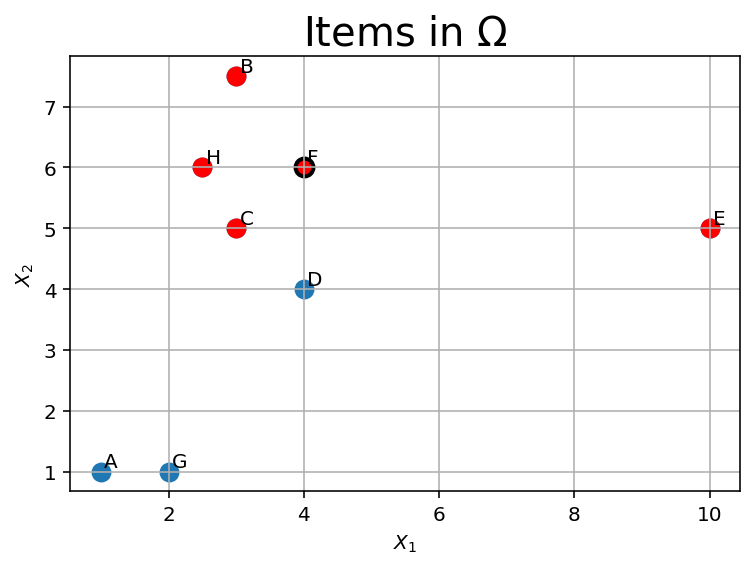

In [11]:
# plot over scatter
# Add new item to S
index = 1 #this is the index of H in Omega'
omega_new = np.hstack([omega,omega_tag[:,index].reshape(2,1)])
E_s_new =np.hstack([E_s,E_s_tag[1]])

top_5_new, chosen_new, rantional_user_val = rec_and_choose(omega_new, alpha)
plot_omega(omega_new, top_5_new, chosen_new)

Print a table of true value, perceived value, and system utility for all top-5 items:

In [12]:
df = pd.DataFrame(columns=("true value", "perceived value", "system utility"))
# df["true value"] = rantional_user_val#[top_5_new]
df["true value"] = [rantional_user_val[i] for i in top_5_new]
df["perceived value"] = a_user(omega_new[:,top_5_new].T)
df["system utility"] = E_s_new[top_5_new]
df

,true value,perceived value,system utility
0,35.0,35.0,30
1,28.5,51.0,20
2,26.0,56.0,80
3,23.0,45.5,8
4,21.0,51.0,30


Notice how $H$ contributed to the perceived value of $F$, just enough to make it more appealing than $E$.

Congrats! The system now gets $e_F=80$ utility! (recall it was 20 before)

1.1.6 Finally, let's compute:
* welfare - this is the actual value to the user from choice
* regret - this is the gap between the percieved value and true value of the chosen item
(if there were more than one user, we would measure the average).

Run the following code blocks and print welfare and regret for Omega before and after adding the additional item.

In [13]:
# welfare
welfare_before = (omega[0,chosen]*alpha[0] +omega[1,chosen]*alpha[1])
welfare_after = (omega_new[0,chosen_new]*alpha[0] +omega_new[1,chosen_new]*alpha[1])
print(f'Welfare before adding the item: {welfare_before}')
print(f'Welfare after adding the item: {welfare_after}')

Welfare before adding the item: 35.0
Welfare after adding the item: 26.0


In [14]:
# regret
regret_before = a_user(omega[:,top_5].T)[chosen-1] - (omega[0,chosen]*alpha[0] + omega[1,chosen]*alpha[1])
regret_after = a_user(omega_new[:,top_5_new].T)[chosen_new-1] - (omega_new[0,chosen_new]*alpha[0] +omega_new[1,chosen_new]*alpha[1])
print(f'Regret before adding the item: {regret_before}')
print(f'Regret after adding the item: {regret_after}')

Regret before adding the item: 17.5
Regret after adding the item: 25.0


### 1.2 **Now You: Find an item to add without any guidance**

In this section, your goal is to repeat the task of finding an item to add, but without guidance - we will just give you the sets $\Omega$ and $\Omega'$.


In [15]:
# New data:
omega = np.array(
    [[6,  8,  8.5,  4,  10, 8,  2,  1],
     [10, 7,  4,    4,  5,  6,  1,  9]]
)
E_s = np.array(
    [10, 90, 30, 50, 30, 40, 100, 90]
)

omega_tag = np.array(
    [[4,  3,  4.5,  6],
     [8,  6,  5,    6]]
)

E_s_tag = np.array(
    [5, 8, 3, 9]
)


1.2.1 Add code in the given blocks to generate relevant scatter plots. Use these to reason about which item to add - write your answer and explanation in the relevant blocks.


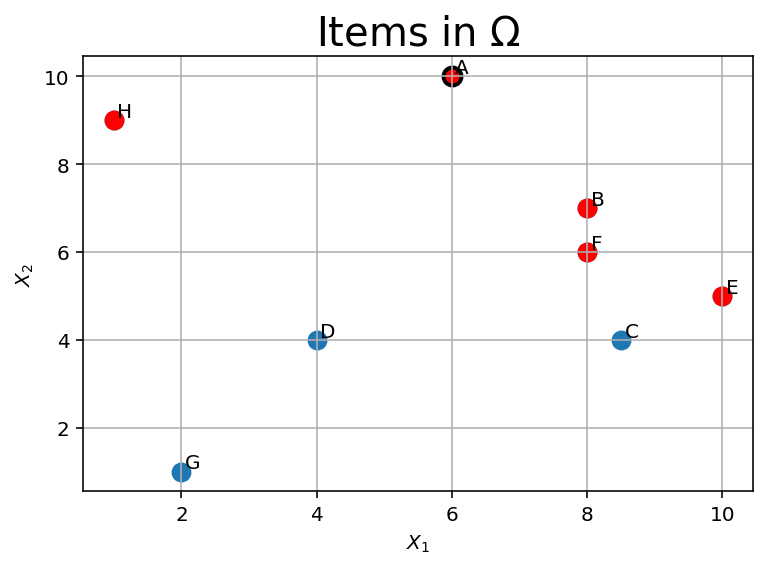

In [16]:
top_5, chosen, rantional_user_val = rec_and_choose(omega, alpha)
plot_omega(omega, top_5, chosen)

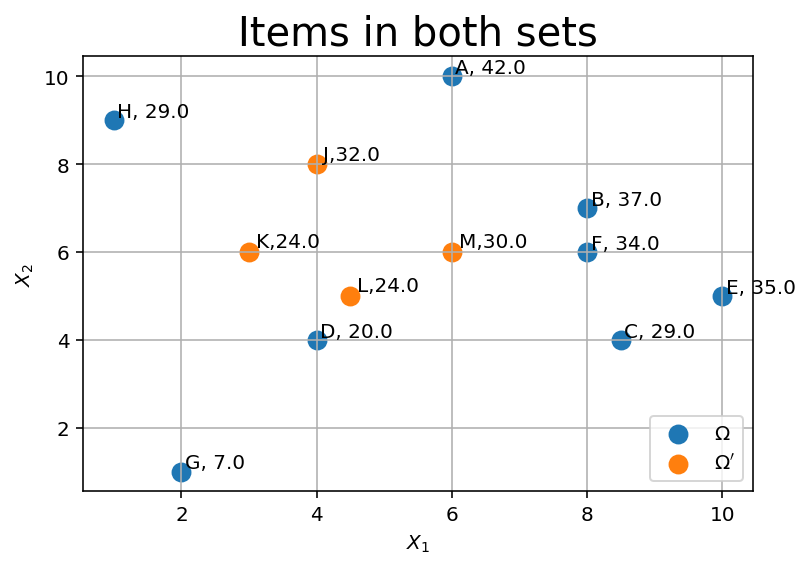

In [17]:
omega_tag_rational_user_val = omega_tag[0,:]*alpha[0] + omega_tag[1,:]*alpha[1]

plot_two_sets(omega,omega_tag)

**Which item will you add and why?** (you can use the code to experiment)

* We will add item (M) (in terms of the previous figure - due to bug in visualization it is item (I) in the next plot).
* Since items (K) & (L) have lower rational utility than (H), adding them have no impact since they will end out of the recommendation set.
* We note that (A) have the lowest system utility, so any other item will be better (from the system perspective).
* Adding (J) makes no sense, since it is only dominated by (A).
* So, adding (M) is our only option. (M) is dominated by (A) as well, but also dominated by (B) and (F).
* Previously, (B) only dominated (F), with a relativly low projected distance compared to (A)->(H) projected distance,
* Now, the reference vector has changed, and (B)->(M) projected distance is bigger. 

1.2.2 Add code to generate the final plot, showing recommendations and choice after you have added the additional item.

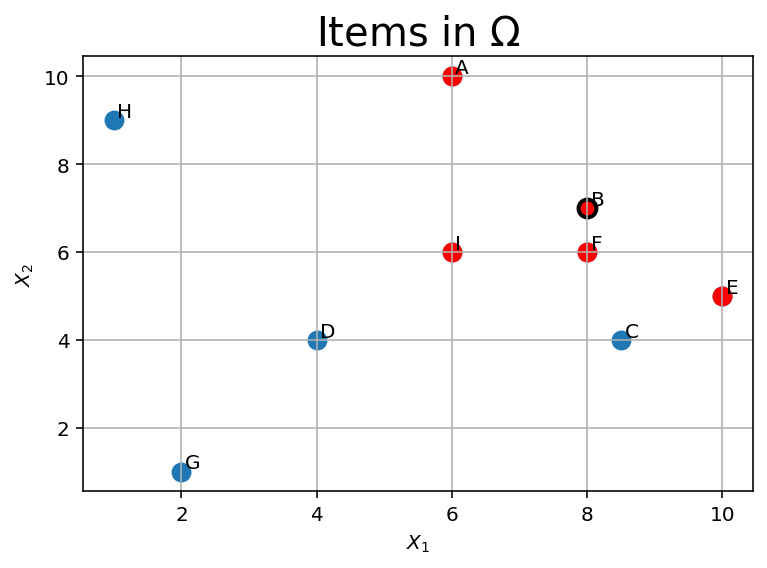

In [18]:
# plot over scatter
# Add new item to S
index = 3 #this is the index of H in Omega'
omega_new = np.hstack([omega,omega_tag[:,index].reshape(2,1)])
E_s_new =np.hstack([E_s,E_s_tag[index]])

top_5_new, chosen_new, rantional_user_val = rec_and_choose(omega_new, alpha)
plot_omega(omega_new, top_5_new, chosen_new)

1.2.3 Calculate welfare and regret for before and after adding the additional item. Print your results.


In [19]:
# welfare
welfare_before = (omega[0,chosen]*alpha[0] +omega[1,chosen]*alpha[1])
welfare_after = (omega_new[0,chosen_new]*alpha[0] +omega_new[1,chosen_new]*alpha[1])
print(f'Welfare before adding the item: {welfare_before}')
print(f'Welfare after adding the item: {welfare_after}')
# regret
regret_before = a_user(omega[:,top_5].T)[chosen-1] - (omega[0,chosen]*alpha[0] + omega[1,chosen]*alpha[1])
regret_after = a_user(omega_new[:,top_5_new].T)[chosen_new-1] - (omega_new[0,chosen_new]*alpha[0] +omega_new[1,chosen_new]*alpha[1])
print(f'Regret before adding the item: {regret_before}')
print(f'Regret after adding the item: {regret_after}')

Welfare before adding the item: 42.0
Welfare after adding the item: 37.0
Regret before adding the item: 136.99999999999997
Regret after adding the item: 5.0


### 1.3 Automate the process
1.3.1 In this section, you will write a simple algorithm that automatically finds the optimal item in $\Omega'$ to add to $\Omega$ in order to maximize system utility.

In particular, your algorithm recieves as input:
* Two sets of items, $\Omega,\Omega'$, where each is a 2D numpy array of sizes $(n,2)$ and $(n',2)$ ($n,n'$ can vary)
* Corresponding system utilities $e_{\Omega}, e_{\Omega'}$, each a numpy array of sizes $n$ and $n'$
* A user model, giving acces to the true value vector $\alpha$ and a choice function .choose().

The algorithm should output:
* The index in $\Omega'$ of the item you wish to add to $\Omega$
* The utility of the system after adding this item

We will give you a collection of 50 example inputs to your algorithm (that is, 50 sets of $(\Omega,\Omega')$ pairs) with $n=15, n'=100$. Write code that applies your algorithm to each of these 50 inputs, and **prints the added items and their corresponding system utilities.**

**Limitations**:
You may call AttractionUserModel *up to 30 times* per input. Write efficient code!

**Bonus:** We will have a competition between submited algorithms. We will run your code on a fresh batch of inputs - the two teams achieving the highest system utility will get 5 bonus points for this exercise.

**WORK ON THIS BONUS ONLY AFTER YOU'VE COMPLETED THE ENTIRE WORKSHOP.** 

In [20]:
# Input
np.random.seed(42) 
num_items_omega = 15

omega_multi = np.random.randint(20,size=(50,num_items_omega,2))
Es_multi = np.random.randint(20,100,size=(50,num_items_omega))

omega_w_multi = np.random.randint(20,size=(50,100,2))
Ew_multi = np.random.randint(20,size=(50,100))

original_system_values = np.zeros(50)
new_system_values = np.zeros(50)

original_user_values = np.zeros(50)
new_user_values = np.zeros(50)

a_user = AttractionUserModel(beta_h=np.array(alpha), alpha_attr=100)

In [21]:
system_utilities = []
walfares_before = []
walfares_after = []
regrets_before = []
regrets_after = []

for i in range(50):
  omega_multi_i = omega_multi[i]
  omega_w_multi_i = omega_w_multi[i]
  Es_multi_i = Es_multi[i]
  Ew_multi_i = Ew_multi[i]

  chosen_before = a_user.choice(omega_multi_i)
  walfares_before.append(a_user(omega_multi_i)[chosen_before])
  regrets_before.append(a_user(omega_multi_i)[chosen_before-1] - walfares_before[-1])
  
  index = np.random.randint(100)
  checked = np.zeros(100)
  checked[index] = 1
  system_utility = -np.Inf
  for j in range(30):
    omega_w_multi_i_j = omega_w_multi_i[index].reshape(1, 2)
    Ew_multi_i_j      = Ew_multi_i[index].reshape(1)
    omega_multi_i_j   = np.concatenate((omega_multi_i, omega_w_multi_i_j))
    Es_multi_i_j      = np.concatenate((Es_multi_i, Ew_multi_i_j))

    perceived = a_user(omega_multi_i_j)
    chosen = a_user.choice(omega_multi_i_j)
    chosen_perceived = perceived[chosen]
    chosen_system_utility = Es_multi_i_j[chosen]
    
    if chosen_system_utility > system_utility:
      system_utility = chosen_system_utility
      walfare_after = chosen_perceived
      regret_after = perceived[chosen-1] - walfare_after

    for x in range(100):
      if checked[x]:
        continue
      omega_w_multi_i_x = omega_w_multi_i[x].reshape(1, 2)
      if (omega_w_multi_i_x[0][0] < omega_w_multi_i_j[0][0]) and \
         (omega_w_multi_i_x[0][1] < omega_w_multi_i_j[0][1]):
        checked[x] = 1
    if np.prod(checked):
      break
    candidates = [k for k in range(100) if checked[k] == 0]
    index = np.random.choice(candidates)
    checked[index] = 1
  
  system_utilities.append(system_utility)
  walfares_after.append(walfare_after)
  regrets_after.append(regret_after)

print(np.mean(system_utilities))
print(np.mean(walfares_before), np.mean(walfares_after))
print(np.mean(regrets_before), np.mean(regrets_after))

63.7
46824.4 47548.4
-18598.88 -19955.14


In [22]:
# Baseline: brute-force search over Omega' (not limited to 30 call per experiment)

system_utilities = []
walfares_before = []
walfares_after = []
regrets_before = []
regrets_after = []

for i in range(50):
  omega_multi_i = omega_multi[i]
  omega_w_multi_i = omega_w_multi[i]
  Es_multi_i = Es_multi[i]
  Ew_multi_i = Ew_multi[i]

  chosen_before = a_user.choice(omega_multi_i)
  walfares_before.append(a_user(omega_multi_i)[chosen_before])
  regrets_before.append(a_user(omega_multi_i)[chosen_before-1] - walfares_before[-1])

  system_utility = -np.Inf
  for j in range(100):
    omega_w_multi_i_j = omega_w_multi_i[j].reshape(1, 2)
    Ew_multi_i_j      = Ew_multi_i[j].reshape(1)
    omega_multi_i_j   = np.concatenate((omega_multi_i, omega_w_multi_i_j))
    Es_multi_i_j      = np.concatenate((Es_multi_i, Ew_multi_i_j))

    perceived = a_user(omega_multi_i_j)
    chosen = a_user.choice(omega_multi_i_j)
    chosen_perceived = perceived[chosen]
    chosen_system_utility = Es_multi_i_j[chosen]

    if chosen_system_utility > system_utility:
      system_utility = chosen_system_utility
      walfare_after = chosen_perceived
      regret_after = perceived[chosen-1] - walfare_after

  system_utilities.append(system_utility)
  walfares_after.append(walfare_after)
  regrets_after.append(regret_after)  

print(np.mean(system_utilities))
print(np.mean(walfares_before), np.mean(walfares_after))
print(np.mean(regrets_before), np.mean(regrets_after))

65.14
46824.4 47199.7
-18598.88 -20831.96


1.3.2 **Explain your algorithm.**

What is the basic principle underlying your implementation? Explain how your approach utilizes the attraction effect.


The basic idea is to release all items in $\Omega'$ that are dominated by a previous checked item.
We hypothesised that such item can't improve the overall system utility (or at least not likly to) because its projected distance is smaller.
The first item in $\Omega'$ is random. Then, all dominated items are released, and then the next item is chosen from the non-dominated items.

Given that you could not evalute all items in in $ֿ\Omega'$ (restriction was 30 out of 100) - how did you prioritize evaluations?

Following previous explanations: using the domination. 

Compute welfare - before and after the change:

In [23]:
print(f'Welfare before adding the item: {np.mean(walfares_before)}')
print(f'Welfare after adding the item: {np.mean(walfares_after)}')
print(f'Regret before adding the item: {np.mean(regrets_before)}')
print(f'Regret after adding the item: {np.mean(regrets_after)}')

Welfare before adding the item: 46824.4
Welfare after adding the item: 47199.7
Regret before adding the item: -18598.88
Regret after adding the item: -20831.96


## Task 2: Prediction and IIA
In this exercise you will examine the sensitivity of different predictive models to behavioral violations of IIA. We will use behavioral choice models, including those you implemented at home, to generate choice behavior that deviates from IIA in different ways. Then, we will evaluate the performance of predictive models trained on generated choice data.

### User models
In the beggining of the notebook you loaded into memory user model classes.
These include: **Rational**, **Similarity**, **Compromise**, and **Attraction**. In this task you will repeat the same learning pipeline for each of these users, and compare results.


### 2.1 Train predictive models

In this section we will compare the performance of two predictive models:
1. MNL, and
2. the pairwise ranker you implemented at home
(as was announced, you may choose the school-solution pairwise ranker instead, but we encourage you to try and work with your own implementation).

2.1.1 Start by generating data. The function generating data (also loaded into memory at the head of the notebook) outputs two objects:
* X: An array of size [num_examples,num_items,num_features] describing num_examples=500 choice sets of num_items=7 items described by num_features=5 features
* Y: A dictionary with keys describing user types and values as arrays of size [num_examples,num_items] of 1-hot choices. The possible user types are: 'Rational', 'Compromise', 'Similarity', and 'Attraction'. For example, Y['Compromise'][i,j] is 1 if compromise-type user $i$ chose item $j$, and 0 otherwise.

(Note: In the "raw" version of the notebook, an exception is thrown because the code for `CompromiseUserModel` does not exist - If the user model from the homework was pasted into the notebook and the cell has run, then re-running the cell below will not cause errors)

In [35]:
 # generate data

num_features = 5
num_items = 7
num_examples = 500
beta_h = np.arange(num_features)

X, y, users_models = generate_data_and_user_selections(num_examples=num_examples, num_items=num_items,num_features=num_features)

2.1.2 Next, for each user type (do this in a for loop over user types):
* Train an MNL model, and evaluate its test performance using the given accuracy() function. 
* Use the X, y inputs generated above. Split them into train and test 70:30.
* Print accuracy.

You are encouraged to wrap your code in a function acc=eval(X,y) that takes as input the data and outputs accuracies for all user types. This will be helpful in the next sections.

Our MNL code uses an external publically available implementation. Below we provide some helper functions and examples on how to use it in our setting.

In [36]:
# utils - helper class for running MNL

def prepare_mnl(X, y):

  """
  handle data for mnl package.
  transforms X to shape [num_round, num_features*num_items+1], appending 1s at the end
  """
  X_mnl = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
  X_mnl = sm.add_constant(X_mnl, prepend=False)
  y_mnl = y.argmax(axis=1)

  return X_mnl, y_mnl


def features_of_chosen_items(X, y):
  X = X[:, :-1]
  X = X.reshape(-1, num_items, num_features)
  chosen = np.take_along_axis(X, y[..., None, None], axis=1)
  chosen = chosen.squeeze()
  return chosen


def perceived_values_of_chosen_items(X, y, user_model):
  X = X[:, :-1]
  X = X.reshape(-1, num_items, num_features)
  if isinstance(user_model, CompromiseUserModel):
    perceived_values = user_model(X)
  else:
    perceived_values = []
    for example in range(X.shape[0]):
      perceived_values.append(user_model(X[example]))
    perceived_values = np.vstack(perceived_values)

  chosen = np.take_along_axis(perceived_values, y[..., None], axis=1)
  chosen = chosen.squeeze()
  return chosen

def accuracy(y, y_pred, model_type):

  """
  given y, y_pred vectors returns accuracy 
  """
  return (y_pred == y).mean()

In [37]:
from sklearn.model_selection import train_test_split
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from warnings import simplefilter

simplefilter("ignore", category=ConvergenceWarning)


def eval_mnl(X, y, users_models):
  accuracies = {}
  chosen_items_features = {}
  chosen_items_values = {}
  for user_type, y_user in y.items():
    x, y_user = prepare_mnl(X, y_user)
    x_train, x_test, y_train, y_test = train_test_split(x, y_user, test_size=0.3, random_state=0)
    mlogit_mod = sm.MNLogit(y_train, x_train)
    mdl_fit = mlogit_mod.fit(method='bfgs', maxiter=10000)
    pred = mdl_fit.predict(x_test).argmax(axis=1)
    accuracies[user_type] = accuracy(y_test, pred, user_type)
    chosen_items_features[user_type] = features_of_chosen_items(x_test, pred)
    chosen_items_values[user_type] = perceived_values_of_chosen_items(x_test, pred, users_models[user_type])

  return accuracies, chosen_items_features, chosen_items_values

In [38]:
mnl_accuracies, mnl_chosen_items_features, mnl_chosen_items_values = eval_mnl(X, y, users_models)
print("user model accuracies with MNL:")
mnl_accuracies

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 1.596191
         Iterations: 141
         Function evaluations: 147
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 1.402326
         Iterations: 145
         Function evaluations: 150
         Gradient evaluations: 150
Optimization terminated successfully.
         Current function value: 0.615341
         Iterations: 297
         Function evaluations: 302
         Gradient evaluations: 302
user model accuracies with MNL:


{'Attraction': 0.47333333333333333,
 'Compromise': 0.13333333333333333,
 'Rational': 0.7266666666666667,
 'Similarity': 0.20666666666666667}

2.1.3 Train your pairwise ranker. Repeat the above procedure.

(make sure you use different named variables for performance measures, so they do not overwrite the MNL results)

In [39]:
from sklearn import svm


def transform_pairwise(X: np.ndarray, y: np.ndarray):
  N, Q = X.shape
  K = N - 1
  Xy = X[y]
  X = np.delete(X, obj=y, axis=0)

  ynew = np.random.choice([-1, 1], size=(K, ))
  Xnew = np.expand_dims(ynew, 1) * (Xy - X)

  return Xnew, ynew


class MyRanker(svm.LinearSVC):
  def shape_transform (self, X, y):
    M, N, Q = X.shape
    K = N - 1

    Xnew, ynew = [], []
    for m in range(M):
      Xnew_, ynew_ = transform_pairwise(X[m], y[m])
      Xnew.append(Xnew_)
      ynew.append(ynew_)
    
    Xnew = np.concatenate(Xnew)
    ynew = np.concatenate(ynew)
    
    return Xnew, ynew
  
  def fit(self, X, y):
    Xnew, ynew = self.shape_transform(X, y)
    super().fit(Xnew, ynew)
  
  def predict(self, X: np.ndarray) -> np.ndarray:
    coef = self.coef_.squeeze()
    intercept = self.intercept_
    v = X @ coef + intercept
    y = np.argmax(v, axis=1)
    return y
  
  def features_of_chosen_items(self, X, y):
    chosen = np.take_along_axis(X, y[..., None, None], axis=1)
    chosen = chosen.squeeze()
    return chosen
  
  def perceived_values_of_chosen_items(self, X, y, user_model):
    if isinstance(user_model, CompromiseUserModel):
      perceived_values = user_model(X)
    else:
      perceived_values = []
      for example in range(X.shape[0]):
        perceived_values.append(user_model(X[example]))
      perceived_values = np.vstack(perceived_values)

    chosen = np.take_along_axis(perceived_values, y[..., None], axis=1)
    chosen = chosen.squeeze()
    return chosen

In [40]:
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from warnings import simplefilter

simplefilter("ignore", category=ConvergenceWarning)


def eval_pw_ranker(X, y, users_models):
  pw_ranker = MyRanker()
  accuracies = {}
  chosen_items_features = {}
  chosen_items_values = {}
  for user_type, y_user in y.items():
    y_user = y_user.argmax(axis=1)
    x_train, x_test, y_train, y_test = train_test_split(X, y_user, test_size=0.3, random_state=0)
    pw_ranker.fit(x_train, y_train)
    pred = pw_ranker.predict(x_test)
    accuracies[user_type] = accuracy(y_test, pred, user_type)
    chosen_items_features[user_type] = pw_ranker.features_of_chosen_items(x_test, pred)
    chosen_items_values[user_type] = pw_ranker.perceived_values_of_chosen_items(x_test, pred, users_models[user_type])

  return accuracies, chosen_items_features, chosen_items_values

In [41]:
pw_ranker_accuracies, pw_ranker_chosen_items_features, pw_ranker_chosen_items_values = eval_pw_ranker(X, y, users_models)
print("user model accuracies with pairwise Ranker:")
pw_ranker_accuracies

user model accuracies with pairwise Ranker:


{'Attraction': 0.5733333333333334,
 'Compromise': 0.06,
 'Rational': 0.9866666666666667,
 'Similarity': 0.29333333333333333}

2.1.4 Plot your results - compare MNL and the pairwise ranker.

Plot a bar graph that compares the performance of each method accorss the differet behavioral models.
* Genarate 3 figures, one for each performance measure: accuracy, welfare and regret.
* For each performance measure, generate a bar plot with 4 bar groups (one per user model), with each group having two bars (one per method).
* Remember to include: title, axis labels, and a lengend.



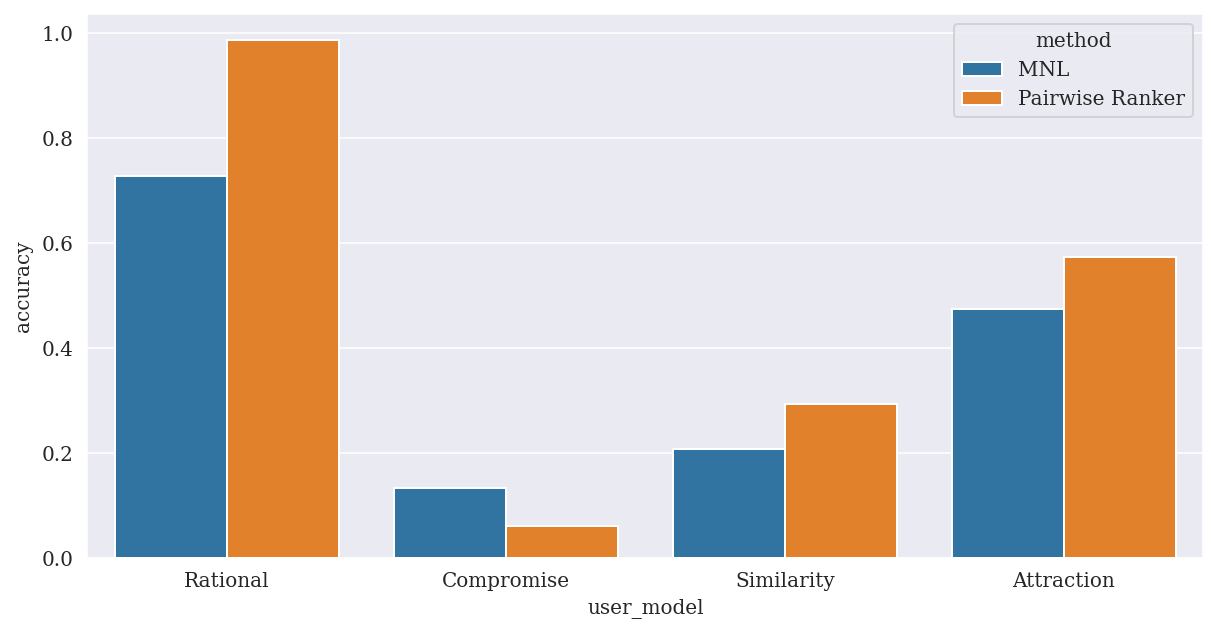

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams["font.family"] = "serif"

mnl_acc_df = pd.DataFrame([dict(user_model=k,accuracy=v) for k, v in mnl_accuracies.items()])
mnl_acc_df["method"] = "MNL"

pw_ranker_acc_df = pd.DataFrame([dict(user_model=k,accuracy=v) for k, v in pw_ranker_accuracies.items()])
pw_ranker_acc_df["method"] = "Pairwise Ranker"

df = pd.concat([mnl_acc_df, pw_ranker_acc_df], ignore_index=True)

_, axs = plt.subplots(figsize=(10, 5))
sns.barplot(data=df, x="user_model", y="accuracy", hue="method", ax=axs)
plt.show()

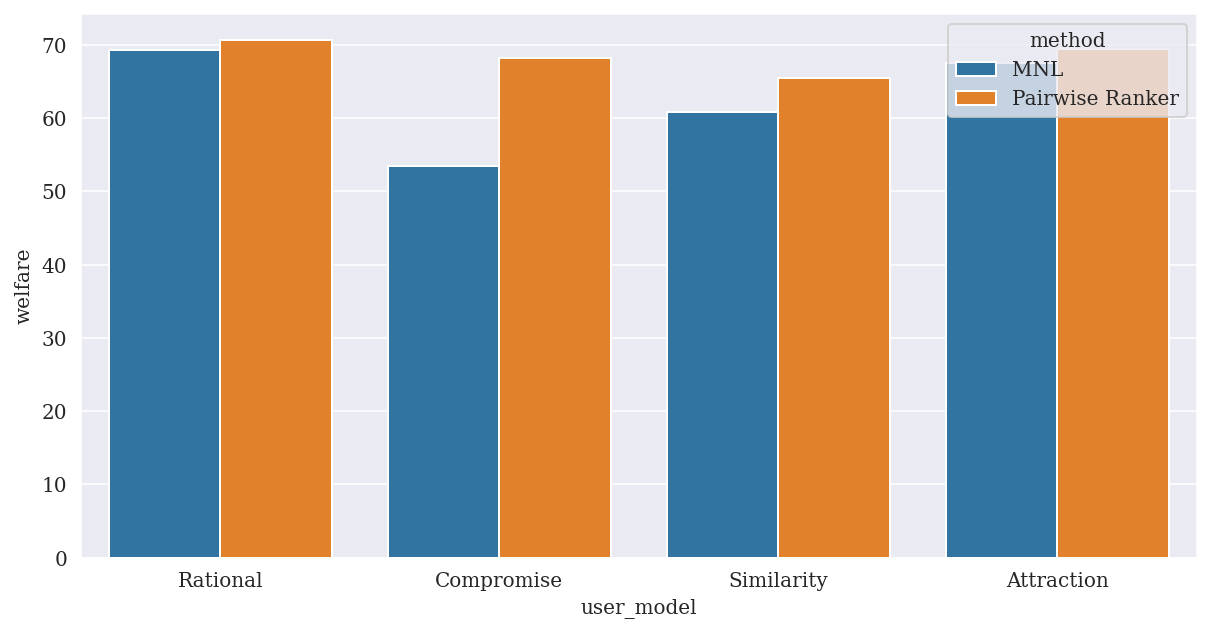

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams["font.family"] = "serif"

mnl_welfare_df = pd.DataFrame([dict(user_model=k,welfare=np.mean(v@beta_h)) for k, v in mnl_chosen_items_features.items()])
mnl_welfare_df["method"] = "MNL"

pw_ranker_welfare_df = pd.DataFrame([dict(user_model=k,welfare=np.mean(v@beta_h)) for k, v in pw_ranker_chosen_items_features.items()])
pw_ranker_welfare_df["method"] = "Pairwise Ranker"

df = pd.concat([mnl_welfare_df, pw_ranker_welfare_df], ignore_index=True)

_, axs = plt.subplots(figsize=(10, 5))
sns.barplot(data=df, x="user_model", y="welfare", hue="method", ax=axs)
plt.show()

2.1.5 Explain your results. What determines differences? What determines similarites? Would you expect these results to hold in general?

In [ ]:
your Answer:...

### 2.2 Varying choice set size


In this section we will evaluate the effect of the number of items in the choice set on performance.

2.2.1 Choose one method - MNL or pairwise ranking. Write code that evaluates your method of choice sets of varying sizes, $|s| \in [3,5,10,20]$.
For each size, randomly generate data, train your model, and calculate test accuracy. Repeat this 5 times and report average accuracy.

Repeat the above procedure for each of the four user types. Store and don't overwrite results.

In [44]:
import pandas as pd


num_features = 5
num_examples = 500
beta_h = np.arange(num_features)

df = pd.DataFrame(columns=("num items", "user model", "accuracy"))
for num_items in (3, 5, 10, 20):
  for i in range(5):
    X, y = generate_data_and_user_selections(num_examples=num_examples, num_items=num_items,num_features=num_features)
    accuracies = eval_pw_ranker(X, y)
    df_tmp = pd.DataFrame({"user model": list(accuracies.keys()), "accuracy": list(accuracies.values())})
    df_tmp["num items"] = num_items

    df = pd.concat([df, df_tmp], ignore_index=True)

df_avg = df.groupby(["num items", "user model"]).mean().reset_index()

ValueError: ignored

2.2.2 Plot your results.

Plot the results using line plot, using $|s|$ for the x-axis and accuracy for the y-axis. Draw one figure, with one line per user type. Add a legend.

NameError: ignored

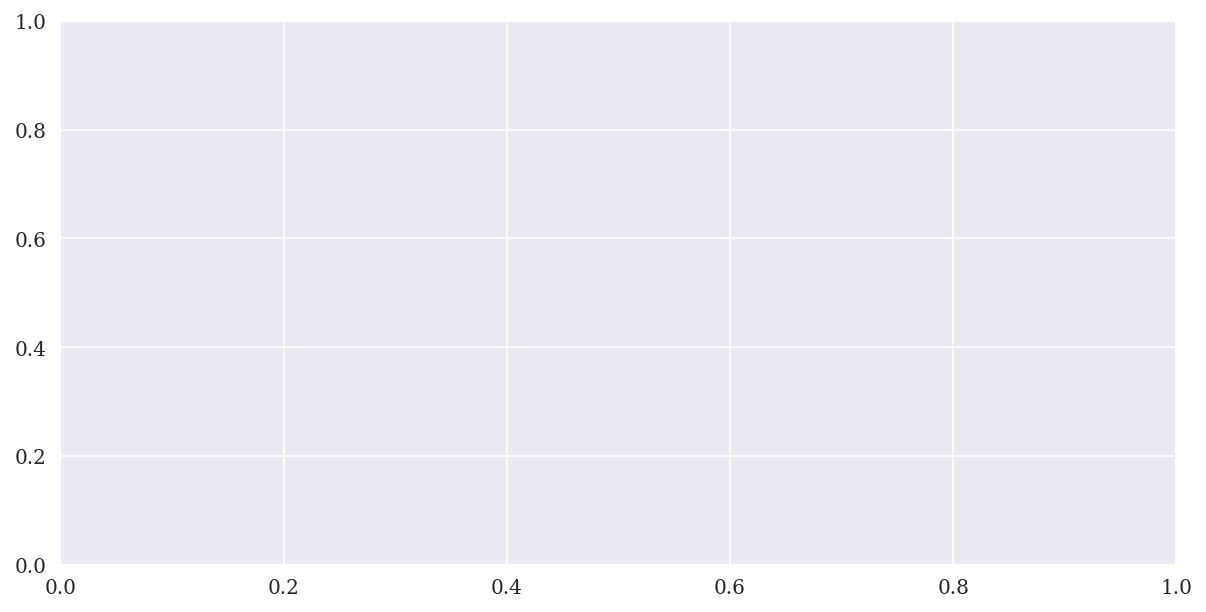

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams["font.family"] = "serif"


_, axs = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df_avg, x="num items", y="accuracy", hue="user model", ax=axs)
plt.show()

## Task 3:  behavioral bias or self-fulfilling prophecy?

In this exercise we move beyond unordered sets, and investigate the importance of ordering on user behavior and on system performance.

In this section, the system provides users with an **ordered** set of items.
The system determines the order of items using a policy implemented in the following BaseRanker() class. Here, the rank() function takes as inputs an (unordered) set of items, and returns them in a specific order, determined by an internal parameter $\hat{\beta}$. We will think of $\hat{\beta}$ as an estimate of a user's internal value vector.

Note that BaseRanker() simply uses *some* $\hat{\beta}$, and there is no learning involved.

In [46]:
np.random.seed(42)

# just data
def generate_synth_data(num_examples, num_features, num_items):
  items = np.random.uniform(low=0.0, high=10.0, size=(num_examples, num_items, num_features))
  return items

In [47]:
class BaseRanker():

  def __init__(self, beta_h_hat):
    self.beta_h = beta_h_hat

  def __call__(self, X):

    return X@self.beta_h
  
  def rank(self, X):
    return np.argsort(-self(X), axis=0)


The following sequence determines one rounds of recommendation and choice:
1. System orders items using BaseRanker
2. Items are displayed to the user as an ordered list
3. User selects an item
4. System stores (i) the chosen item, and (ii) the item's position in the ordered list

The next block of code loads an array describing the positions of chosen items across multiple rounds. Choices are generated by an **unknown** user model called XUserModel, in response to a BaseRanker ranker (having some $\hat{\beta}$).

In [48]:
x_user_choice_positions = np.load('x_user_click_positions.npy')

FileNotFoundError: ignored

3.0.1 Plot a line graph: user choice vs. displayed position.



NameError: ignored

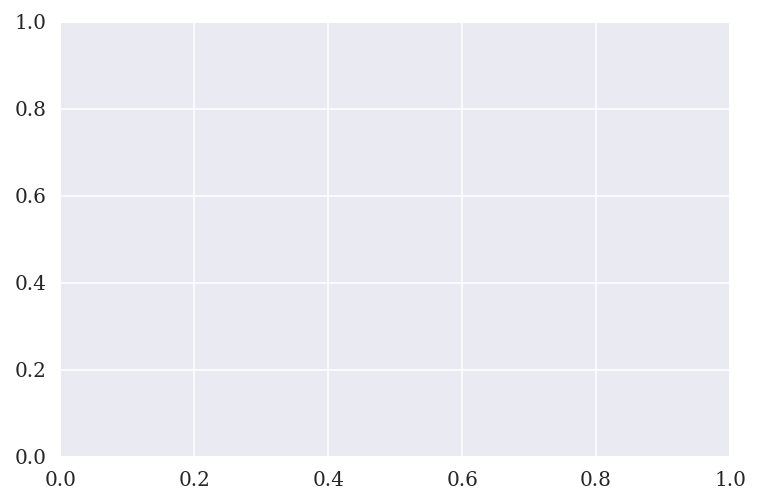

In [49]:
import matplotlib.pyplot as plt

_, axs = plt.subplots()
axs.hist(x_user_choice_positions, bins=[i - 0.5 for i in range(7)] + [6.5], rwidth=0.75)
axs.set_xticks(list(range(7)))
axs.set_xticklabels([str(i) for i in range(7)])
plt.show()

3.0.2 Does user behavior showcase order bias?
Explain your answer.

Not necessarily. The above shows a high correlation between how the BaseRanker orders the items and x_user choose them. This correlation does not indicate causation.

### 3.1 Learning to rank

Next, let's examine the preformance of a *learning-based* ranker.

Train a ranking-based recommender using the XGBoost ranker package
and with the pairwise objective function (this is useful for ranking).

*Note: XGBoost is a widely used machine learning library, which uses gradient boosting techniques to build a better model by combining multiple weak models.*

*Note:* XGBoost ranker takes into account the set of item by setting a certain 'group' attribute, but does not take position into account.

First, load the package:

In [50]:

import xgboost as xgb

class_weights = {1:100, 2:10}

model = xgb.XGBRanker(  
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75,
    class_weights =  class_weights
    )

In the next block of code, you will load into memory an instance of XUserModel. **This code his hidden from you** - consider XUserModel() as a black box which you may only use to generate choice behavior for ordered list inputs.

**Follow these steps carefully:**
1. Press the 'Play' icon to run the block of code
2. Do **NOT** double click on the title (we will see if you did this...)
3. You may **NOT** access xuser's code in any other way, modify it, or change xuser's instantiation.

In [53]:
#@title xuser


class XUserModel(UserModel):

  def __init__(self, num_features, beta_h, c, beta_p, c_p=0):
    self.num_features = num_features
    self.beta_1 = np.arange(num_features)
    self.beta_2 = beta_p
    self.c = c
    self.c1 = c_p
    self.beta_3 = self.beta_1 + self.c * self.beta_2

  def __call__(self, X):
    pos = np.arange(X.shape[0])
    z = X@self.beta_1
    z_ = X@self.beta_3 + self.c*pos
    z_ip = z_ + self.c* np.random.randn(X.shape[0])
    z_p = z + self.c* np.random.randn(X.shape[0])
    b = z_ip + z_p 
    z_b = z_p + self.c1*b
    return z_b
  
  def select(self, X):
    return np.argmax(self(X), axis=0)

beta_h = np.arange(5)
x_click_user = XUserModel(5, beta_h, c=0.7, beta_p=beta_h)

The next blocks of code run the following preparation steps:
* Initialize BaseRanker
* Generate examples
* Sort by BaseRanker
* Prepare inputs for XGBoost ranker
* Train the ranker

In [54]:
# input is flatten for XGBRanker
np.random.seed(42)
num_rounds = 500
num_items = 7
num_features = 5
beta_h = np.arange(num_features)

X = generate_synth_data(num_rounds, num_features, num_items)
base_ranker = BaseRanker(beta_h)
x_user_click_positions = np.zeros(X.shape[0])
y_x = np.ones((num_rounds, num_items)) * 2 # holds ground truth
X_flatten = np.zeros((X.shape[1]*X.shape[0], X.shape[2]+1))
y_pos = np.zeros(num_rounds) # holds round truth
X_display = list()

# sort by BaseRanker & generate user clicks
for i in range(X.shape[0]):
  ranks = base_ranker.rank(X[i])
  X_display.append(X[i][ranks])
  selection = x_click_user.select(X_display[i])
  y_x[i, selection] = 1
  y_pos[i] = selection

# round_id is inserted so predictions would be made per group
X_flatten[:,0] = np.repeat(np.arange(num_rounds), num_items)
X_flatten[:,1:] = np.vstack(X_display)
df = pd.DataFrame(X_flatten)

In [55]:
from sklearn.model_selection import GroupShuffleSplit

np.random.seed(42)

def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['id'])])

df['rank'] = y_x.flatten()
df.rename(columns={0:'id'}, inplace=True)
gss = GroupShuffleSplit(test_size=.30, n_splits=1, random_state = 42).split(df, groups=df['id'])
X_train_inds, X_test_inds = next(gss)
train_data = df.iloc[X_train_inds]
test_data = df.iloc[X_test_inds]

X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank'])]
y_train = train_data.loc[:, train_data.columns.isin(['rank'])]
groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

# fit model
model.fit(X_train, y_train, group=groups, verbose=True)

# test model
test_features= test_data.loc[:, ~df.columns.isin(['rank'])]
test_group_ids = test_data['id'].unique()

pred_values = (test_features.groupby('id').apply(lambda x: predict(model, x)))

# translate to positions
click_predictions = pred_values.apply(lambda x: np.argmin(x))

# evaluate accuracy
print(f'Accuracy: {np.sum(click_predictions == y_pos[test_group_ids.astype(int)])/len(test_group_ids)}')

Accuracy: 0.82


3.1.1 Build a wrapper class for the XGBoost ranker that improves it's predictive perfomance. 

Recall that the ranker does not make use of information regarding the position of items in the ranked list. Think of how you can utilize this for training better predictive models, but using learning-to-rank as your core method.

Note that to use the ranker for xuser choices, choices are transformed intopartial ranks. For example, if the ordered list includes three items, and the user chose the third item, then the input to the ranker is of the form (2,2,1), where 1 encodes 'chosen' and 2 encodes 'not chosen'.


In [56]:
class AugXGBRanker(xgb.XGBRanker):

  @staticmethod
  def aug_with_ranks(df):
    return df.assign(**{"ranks": df.index.values % num_items})

  def fit(self, X_train, y_train, group, verbose=True):
    X_train = self.aug_with_ranks(X_train)
    super().fit(X_train, y_train, group, verbose=True)


def predict(model, df):
  df = AugXGBRanker.aug_with_ranks(df)
  return model.predict(df.loc[:, ~df.columns.isin(['id'])])

3.1.2 Explain your reasoning behind your algorithm.

In [ ]:
Answer: ... 

3.1.3 Train and evaluate your new ranker on the same data as. Print accuracy, and compare it to the original ranker.

In [57]:
model = AugXGBRanker(  
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75,
    class_weights =  class_weights
    )

# fit model
model.fit(X_train, y_train, group=groups, verbose=True)

# test model
test_features = test_data.loc[:, ~df.columns.isin(['rank'])]
test_group_ids = test_data['id'].unique()

pred_values = (test_features.groupby('id').apply(lambda x: predict(model, x)))

# translate to positions
click_predictions = pred_values.apply(lambda x: np.argmin(x))

# evaluate accuracy
print(f'Accuracy: {np.sum(click_predictions == y_pos[test_group_ids.astype(int)])/len(test_group_ids)}')

Accuracy: 0.9666666666666667


3.1.4 Examine the relation between choices and item position.

Plot a histogram of the number of items chosen overall per item position (i.e., have one bar in the histogram for each possible position, where the height of the bar is the number of items that where chosen that were at that position).


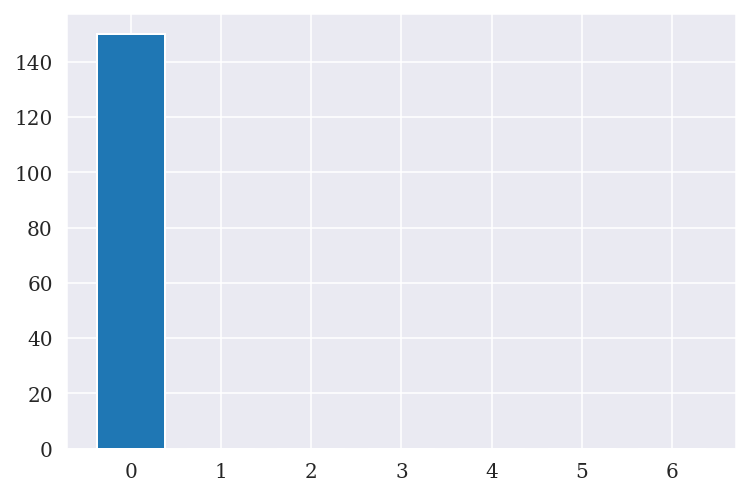

In [58]:
import matplotlib.pyplot as plt

_, axs = plt.subplots()
axs.hist(click_predictions, bins=[i - 0.5 for i in range(7)] + [6.5], rwidth=0.75)
axs.set_xticks(list(range(7)))
axs.set_xticklabels([str(i) for i in range(7)])
plt.show()

3.1.5 Does the plot align with your expectations? Explain.

In [ ]:
Answer: ...

### 3.2 User Behavior Analysis

In the previous tasks you examined the relationship between postion in the list and choice behavior. While plotting them together may *suggest* of a possible connection between them, one cannot infer the *cause* for this relationship.

**Don't confuse correlation with causation!**

3.2.1 Write an algorithm that *determines* whether a user model *really* exhibits order bias, and attempt to quantify the extent of this bias.

**Think**: How should you approach this?

Start by explicitly writing your approach (in text), and only then proceed to writing this in code.

**Hint**: You can use the given xuser to run "experiments".

In [ ]:
Answer:...

In [ ]:
"""

YOUR CODE 
"""

3.2.2 Now that you've implemented your validation procedure, use it to determine which of the following **three user models** (called 'click models') are prone to order bias, and to what extent.

Explain your results, and support your claims using appropriate bar plot(s).

In [ ]:
# click-model classes

class AUserModel(UserModel):
  def __init__(self, num_features):
    self.num_features = num_features
    
  def __call__(self, X):
    return 1

  def select(self, X):
    return 1

class BUserModel(UserModel):
  def __init__(self,beta_h=np.arange(num_features), c=5):
    print(f'beta_h: {beta_h}')
    self.num_features = num_features
    self.beta_h = beta_h
    self.c = c

  def __call__(self, X):

    return X@np.arange(num_features) - self.c*np.arange(X.shape[0])
  
  def select(self, X):
    return np.argmax(self(X), axis=0)

class CUserModel(UserModel):

  def __init__(self,beta_h=np.arange(num_features)):
    self.num_features = num_features
    self.beta_h = beta_h

  def __call__(self, X):
    penalty = np.zeros(X.shape[0])
    penalty[1] = 8
    return X@np.arange(num_features) - penalty
  
  def select(self, X):
    return np.argmax(self(X), axis=0)


In [ ]:
beta_h = np.arange(num_features)
a_click_user = AUserModel(num_features)
b_click_user = BUserModel(num_features)
c_click_user = CUserModel(num_features)

In [ ]:
"""

YOUR IMPLEMNTATION GOES HERE

"""

Run you procedure on the three user models:

In [ ]:
"""

YOUR CODE GOES HERE

"""

Provide relevant plots:

In [ ]:
"""
YOUR PLOT
"""